# Project 3: Web APIs & NLP

---

## Part 2: Data Cleaning & EDA

### Contents:

- [Data Cleaning](#Data-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)

---

#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from bs4 import BeautifulSoup

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [2]:
# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 400

#### Read in datasets

In [3]:
ps4 = pd.read_csv("../datasets/ps4.csv")
ps5 = pd.read_csv("../datasets/ps5.csv")

In [4]:
ps4.head()

,subreddit,id,title,selftext,removed_by_category,created_utc
0,PS4,vobsxp,help,[removed],moderator,1656604717
1,PS4,vobgp9,How long do you play a game before you decide to give up on it?,"I know that some games take some time to really get into them. However, I am curious how long it takes you all before you realize the game just isn’t for you and to move on?\n\nHow many days or hours? Been hitting a rough patch with games lately!",NaN,1656603840
2,PS4,vobdsi,"Updating PS4 via Usb, questions.",[removed],moderator,1656603632
3,PS4,vob0uc,God of War Ragnarok Release Date Announcement Delayed [Rumor],NaN,NaN,1656602691
4,PS4,vob0m1,can someone help with ps4 blurryness on brand new tv,[removed],moderator,1656602676


In [5]:
ps4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9992 entries, 0 to 9991
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   subreddit            9992 non-null   object
 1   id                   9992 non-null   object
 2   title                9992 non-null   object
 3   selftext             8436 non-null   object
 4   removed_by_category  7109 non-null   object
 5   created_utc          9992 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 468.5+ KB


In [6]:
ps4.shape

(9992, 6)

In [7]:
ps5.head()

,subreddit,id,title,selftext,removed_by_category,created_utc
0,PS5,vobq9m,F.I.S.T.: Forged In Shadow Torch | Retail Editions Trailer,NaN,NaN,1656604528
1,PS5,vobl0a,Mouse Lag On Warzone,[removed],reddit,1656604142
2,PS5,vobhpk,PS5 wont show me the disney plus app,[removed],reddit,1656603908
3,PS5,vobddg,"F1 22: Silverstone Circuit Hot Lap, On Board with Lewis Hamilton. @F1® Games From Codemasters",NaN,NaN,1656603605
4,PS5,vobb3h,Tom Henderson reveals details about God of War Ragnarök Collectors’ editions,NaN,NaN,1656603436


In [8]:
ps5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9992 entries, 0 to 9991
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   subreddit            9992 non-null   object
 1   id                   9992 non-null   object
 2   title                9992 non-null   object
 3   selftext             6032 non-null   object
 4   removed_by_category  3092 non-null   object
 5   created_utc          9992 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 468.5+ KB


In [9]:
ps5.shape

(9992, 6)

## Data Cleaning

In [10]:
# Check for null values
ps4.isnull().sum()

subreddit                 0
id                        0
title                     0
selftext               1556
removed_by_category    2883
created_utc               0
dtype: int64

In [11]:
ps5.isnull().sum()

subreddit                 0
id                        0
title                     0
selftext               3960
removed_by_category    6900
created_utc               0
dtype: int64

In [12]:
# Check for duplicates
ps4.duplicated().sum()

0

In [13]:
ps5.duplicated().sum()

0

In [14]:
ps4['removed_by_category'].value_counts()

moderator           6300
reddit               780
deleted               28
automod_filtered       1
Name: removed_by_category, dtype: int64

Posts that are removed from its subreddit will be marked with the above categories. Hence, we will mask these posts and keep the undeleted posts for our analysis.

In [15]:
# Mask deleted posts
ps4 = ps4[ps4['removed_by_category'].isnull()]

In [16]:
ps4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2883 entries, 1 to 9990
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   subreddit            2883 non-null   object
 1   id                   2883 non-null   object
 2   title                2883 non-null   object
 3   selftext             2006 non-null   object
 4   removed_by_category  0 non-null      object
 5   created_utc          2883 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 157.7+ KB


The null values in `selftext` and `removed_by_category` will be replaced with blank strings.

In [17]:
# Replace NaN values with blank strings
ps4['selftext'].fillna(' ', inplace=True)
ps4['removed_by_category'].fillna(' ', inplace=True)

In [18]:
ps4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2883 entries, 1 to 9990
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   subreddit            2883 non-null   object
 1   id                   2883 non-null   object
 2   title                2883 non-null   object
 3   selftext             2883 non-null   object
 4   removed_by_category  2883 non-null   object
 5   created_utc          2883 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 157.7+ KB


In [19]:
# Drop removed_by_category and created_utc
ps4.drop(['removed_by_category', 'created_utc'], axis=1, inplace=True)

In [20]:
#  Reset index
ps4.reset_index(drop=True, inplace = True)

In [21]:
ps4.head()

,subreddit,id,title,selftext
0,PS4,vobgp9,How long do you play a game before you decide to give up on it?,"I know that some games take some time to really get into them. However, I am curious how long it takes you all before you realize the game just isn’t for you and to move on?\n\nHow many days or hours? Been hitting a rough patch with games lately!"
1,PS4,vob0uc,God of War Ragnarok Release Date Announcement Delayed [Rumor],
2,PS4,vob0ek,One Piece Odyssey - Gameplay,
3,PS4,voaq7b,One Piece Odyssey - Dev Diary,
4,PS4,vo9fc1,Upgrade Ps4 to Ps5,I have the original Ps4 and can no longer run a lot of the mainstream multiplayer games without my console crashing. I have finally found a few Ps5 consoles in my area and am curious if Ps5 users think the upgrade was worth it?


In [22]:
ps4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2883 entries, 0 to 2882
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  2883 non-null   object
 1   id         2883 non-null   object
 2   title      2883 non-null   object
 3   selftext   2883 non-null   object
dtypes: object(4)
memory usage: 90.2+ KB


In [23]:
# Perform the same for ps5 dataset

# Mask deleted posts
ps5 = ps5[ps5['removed_by_category'].isnull()]

# Replace NaN values with blank strings
ps5['selftext'].fillna(' ', inplace=True)
ps5['removed_by_category'].fillna(' ', inplace=True)

# Drop removed_by_category and created_utc
ps5.drop(['removed_by_category', 'created_utc'], axis=1, inplace=True)

#  Reset index
ps5.reset_index(drop=True, inplace = True)

In [24]:
ps5.head()

,subreddit,id,title,selftext
0,PS5,vobq9m,F.I.S.T.: Forged In Shadow Torch | Retail Editions Trailer,
1,PS5,vobddg,"F1 22: Silverstone Circuit Hot Lap, On Board with Lewis Hamilton. @F1® Games From Codemasters",
2,PS5,vobb3h,Tom Henderson reveals details about God of War Ragnarök Collectors’ editions,
3,PS5,vob6le,So will more ps3 games be added to the new ps plus?,"So I’m enjoying playing though some of the ps3 catalog though the new PS plus, however I noticed some games that I was hoping that would show up, aren’t there. So I was wondering if more will be added.\n\nCause I really want to play Killzone 2"
4,PS5,vob13g,God of War Ragnarok Release Date Announcement Delayed,


In [25]:
ps5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6900 entries, 0 to 6899
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  6900 non-null   object
 1   id         6900 non-null   object
 2   title      6900 non-null   object
 3   selftext   6900 non-null   object
dtypes: object(4)
memory usage: 215.8+ KB


## Exploratory Data Analysis

CountVectorizer will be used to obtain the most frequently occurring words from `title` and `selftext`in both subreddits.

In [26]:
# Instantiate CountVectorizer
cvec = CountVectorizer(max_features = 1000,
                       stop_words = 'english'
                      )

In [27]:
ps4_title = pd.DataFrame(cvec.fit_transform(ps4['title']).todense(),
                            columns = cvec.get_feature_names_out())

ps4_title_30 = ps4_title.sum().sort_values(ascending=False).head(30)

In [28]:
ps5_title = pd.DataFrame(cvec.fit_transform(ps5['title']).todense(),
                            columns = cvec.get_feature_names_out())

ps5_title_30 = ps5_title.sum().sort_values(ascending=False).head(30)

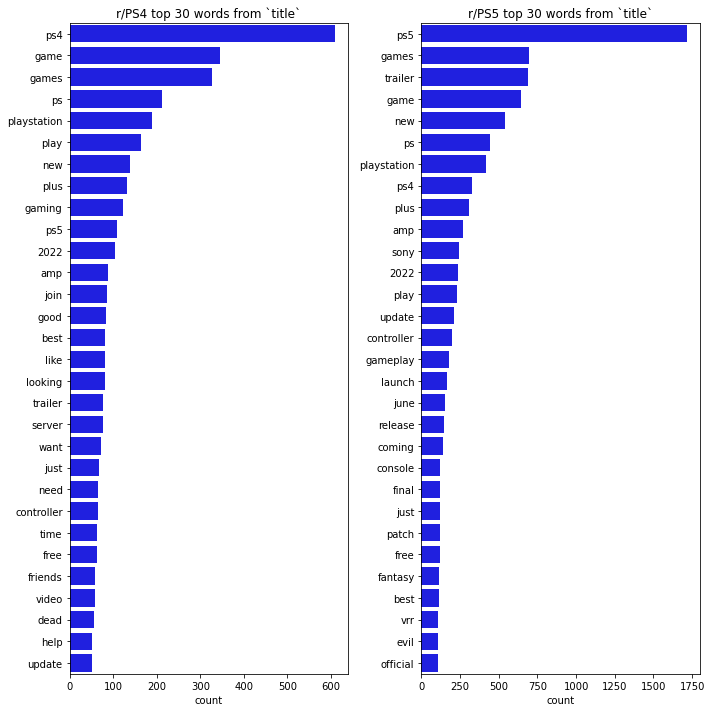

In [29]:
# Plot results for `title`
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10,10))

sns.barplot(y=ps4_title_30.index.values, x=ps4_title_30, color='blue', ax=ax[0]);
ax[0].set_title('r/PS4 top 30 words from `title`')
ax[0].set_xlabel('count')

sns.barplot(y=ps5_title_30.index.values, x=ps5_title_30, color='blue', ax=ax[1]);
ax[1].set_title('r/PS5 top 30 words from `title`')
ax[1].set_xlabel('count')

plt.tight_layout()
plt.show()

In [30]:
ps4_selftext = pd.DataFrame(cvec.fit_transform(ps4['selftext']).todense(),
                            columns = cvec.get_feature_names_out())

ps4_selftext_30 = ps4_selftext.sum().sort_values(ascending=False).head(30)

ps5_selftext = pd.DataFrame(cvec.fit_transform(ps5['selftext']).todense(),
                            columns = cvec.get_feature_names_out())

ps5_selftext_30 = ps5_selftext.sum().sort_values(ascending=False).head(30)

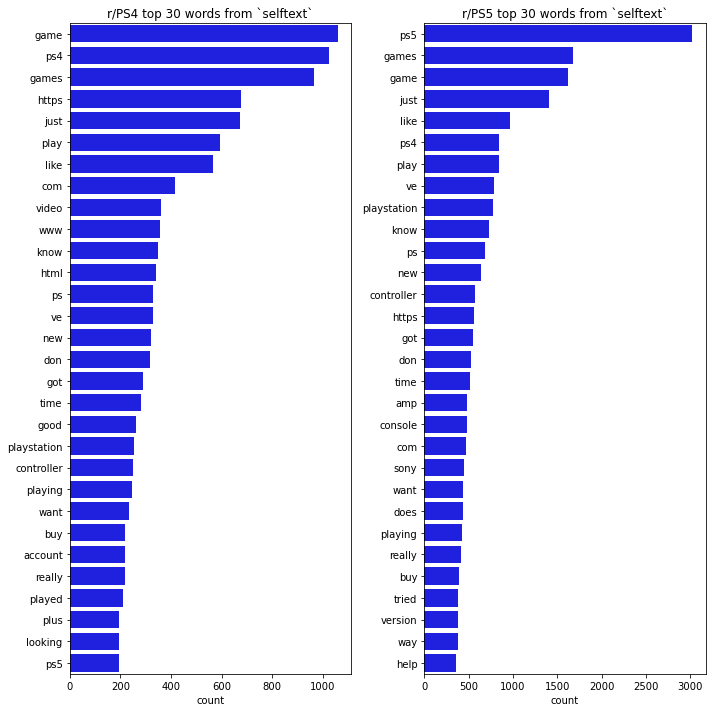

In [31]:
# Plot results for `selftext`
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10,10))

sns.barplot(y=ps4_selftext_30.index.values, x=ps4_selftext_30, color='blue', ax=ax[0]);
ax[0].set_title('r/PS4 top 30 words from `selftext`')
ax[0].set_xlabel('count')

sns.barplot(y=ps5_selftext_30.index.values, x=ps5_selftext_30, color='blue', ax=ax[1]);
ax[1].set_title('r/PS5 top 30 words from `selftext`')
ax[1].set_xlabel('count')

plt.tight_layout()
plt.show()

We can consider including the common words from both subreddits such as 'game', 'playstation', 'ps4' and 'ps5' into our list of stopwords during data preprocessing, as these words may not be helpful in differentiating an unclassified post. N-grams can be reviewed as well, as it could consist of differentiators such as technical terms or game titles.

In [32]:
# Instantiate CountVectorizer
cvec = CountVectorizer(max_features = 1000,
                       stop_words = 'english',
                       ngram_range = (2,4))

In [33]:
ps4_features = pd.DataFrame(cvec.fit_transform(ps4['title']).todense(),
                            columns = cvec.get_feature_names_out())

ps4_features_30 = ps4_features.sum().sort_values(ascending=False).head(30)

ps5_features = pd.DataFrame(cvec.fit_transform(ps5['title']).todense(),
                            columns = cvec.get_feature_names_out())

ps5_features_30 = ps5_features.sum().sort_values(ascending=False).head(30)

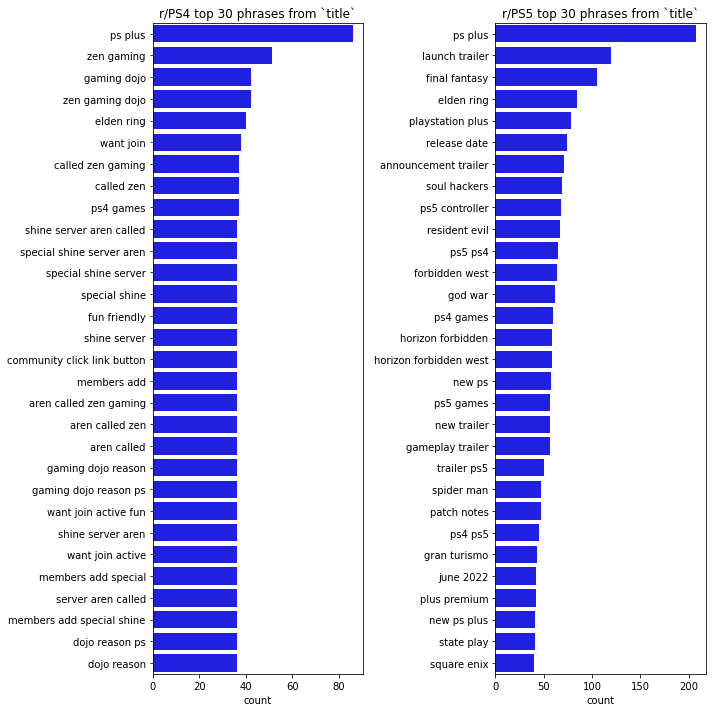

In [34]:
# Plot results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10,10))

sns.barplot(y=ps4_features_30.index.values, x=ps4_features_30, color='blue', ax=ax[0]);
ax[0].set_title('r/PS4 top 30 phrases from `title`')
ax[0].set_xlabel('count')

sns.barplot(y=ps5_features_30.index.values, x=ps5_features_30, color='blue', ax=ax[1]);
ax[1].set_title('r/PS5 top 30 phrases from `title`')
ax[1].set_xlabel('count')

plt.tight_layout()
plt.show()

In [35]:
ps4.to_csv("../datasets/ps4_clean.csv", index=False)
ps5.to_csv("../datasets/ps5_clean.csv", index=False)